# GeoML with EuroSAT and TorchGeo
I developed this notebook for Week 2 of a course, AI for Good, that I co-teach with [Professor Zia Mehrabi](https://www.colorado.edu/envs/zia-mehrabi). In the previous week, we learned how to use Pytorch for machine learning with a simple MLP. This week, we're going to use a related library designed to work with geospatial data and models within PyTorch called [TorchGeo](https://github.com/microsoft/torchgeo). The documentation is [here](https://torchgeo.readthedocs.io/en/latest/) and the associated publication from 2021 [here](https://arxiv.org/abs/2111.08872). It is an active community and well maintained repository that is super useful especially for pulling in existing models and working with satellite imagery and geospatial datasets. 

![eurosat-banner](eurosat.png)

In this notebook, we'll be using a benchmark dataset called "EuroSAT" that includes 27,000 satellite image patches from Sentinel-2 over Europe along with a label about what the image is of. This is a more complex dataset, and so we'll need a deeper neural network to classify the images. We'll create a commonly-used type of convolutional neural network (CNN) used for image classifcation, [ResNet](https://arxiv.org/abs/1512.03385), and compare the performance of randomly initialized weights versus pretrained weights.

**Learning Outcomes**:
- Learn the basics of the TorchGeo API
- Learn an API for working with satellite imagery
- Train a Convolutional Neural Network for image classification
- Learn to pull pretrained weights for a model and compare performance

## Environment Setup

Before we start, we'll definitely want to use GPUs for this task since the dataset and the neural network are much larger than we were using before. A ResNet18 has about 11 million parameters and the EuroSAT dataset has about 2GB of data. This pales compared to 1.76 trillion parameters in GPT-4 (about 10^5 times smaller), but we're not OpenAI, everyone starts somewhere.

In [68]:
import pandas as pd
import os

# data libraries
from torch.utils.data import DataLoader
from torchgeo.datasets import EuroSAT
import random
import datetime
import matplotlib.pyplot as plt

# ml libraries
import torch # for model training
from torch import nn # for neural network layers
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader
from torchvision.transforms import v2 as transforms

print("import complete")

import complete


## Download and Visualize EuroSat Data

We'll be classiying the EuroSAT dataset from [this 2017 paper](https://arxiv.org/abs/1709.00029). The images are from the [Sentinel-2 satellite constellation](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2) from the European Space Agency. It takes multi-spectral (visible light plus some longer wavelengths) images of all land on Earth every 5 days at 30-meter spatial resolution.

Instead of downloading the dataset to our computers then uploading to Kaggle, we will use the `torchgeo` API to pull in the dataset. It will download a `.zip` will all of the images, and then 3 `.txt` files that contain a list of the filenames of each images for training, validation, and test data. This is standard for datasets in `torchgeo`. This also means that the images won't get loaded in memory until we actually need them, hooray for efficiency!

In this next section, we use the torchgeo dataset/datamodules to download the EuroSat dataset. We also calculate the number of samples in each split and visualize an image or two.

In [69]:
eurosat_root = os.path.join("data", "eurosat")
eurosat_dataset_train = EuroSAT(eurosat_root, split="train", download=True)
eurosat_dataset_val = EuroSAT(eurosat_root, split="val", download=True)
eurosat_dataset_test = EuroSAT(eurosat_root, split="test", download=True)

print(f'Dataset Classes: {eurosat_dataset_train.classes}')
print(f'Number of images in train dataset: {len(eurosat_dataset_train)}')
print(f'Number of images in val dataset: {len(eurosat_dataset_val)}')
print(f'Number of images in test dataset: {len(eurosat_dataset_test)}')

Dataset Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Number of images in train dataset: 16200
Number of images in val dataset: 5400
Number of images in test dataset: 5400


### # of Images in Each Dataset Split
Split    | %            | EuroSAT   |
---------|-----------   |---------  |
Train    |  60          |   16200   |
Validate |  20          |   5400    |
Test     |  20          |   5400    |

### Visualize Images and Labels

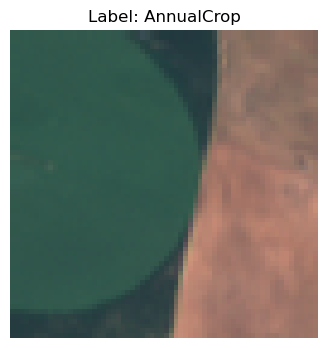

In [70]:
# visualize just one image
fig = eurosat_dataset_train.plot(
    sample=eurosat_dataset_train.__getitem__(1),
    show_titles=True
)

# modify this code to inspect a few different images and get a sense of the labels

## Train & Evaluate a Model on the EuroSAT Data 

In this section, we train two ResNet models on the nonspatial EuroSat dataset: one with randomly initialized weights, and one with pre-initialized weights from the SSL4EO-S12 project (use the pretrained weights available in torchgeo).

The flow of this section is as follows:
1. Configure the GPU
1. Define the train and test loops
1. Define a ResNet model with random weights, customize the model for EuroSat data
1. Define a data sampler and loader
1. Load and transform the data
1. Train & evaluate the model
1. Repeat with a pre-trained ResNet
1. Report results

#### Configure GPU

This should output `cuda` if you activated the GPU.

In [71]:
# set seed for reproducibility
torch.manual_seed(44)

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


### Configure CPU for Loading Data

In [72]:
# see how many processes can be run on the CPU
import multiprocessing
pool = multiprocessing.Pool()
pool._processes

14

#### Define the Train & Test Loops

These are pulled from the pytorch getting started tutorial. I've added a comment to every single line to explain what the code is doing to help demystify it.

In [73]:
# Define the training loop function
def train(dataloader, model, loss_fn, optimizer):
    # Get the total number of samples in the dataset
    size = len(dataloader.dataset)
    # Set the model to training mode
    model.train()
    
    # Loop through batches of data provided by the dataloader
    for batch, sample in enumerate(dataloader):
        # Extract input data (images) and corresponding labels from the batch
        X, y = sample['image'], sample['label']
        # Move the input data and labels to the specified device (e.g., GPU or CPU)
        X, y = X.to(device), y.to(device)
        
        # Forward pass: Compute the model's predictions for the inputs
        pred = model(X)
        # Compute the loss between predictions and true labels
        loss = loss_fn(pred, y)

        # Backpropagation: Compute gradients of the loss with respect to model parameters
        loss.backward()
        # Update model parameters using the optimizer
        optimizer.step()
        # Reset gradients to zero to prevent accumulation
        optimizer.zero_grad()

        # print another period after each batch to track progress
        print('.', end='', flush=True)

print("train loop defined")

train loop defined


In [74]:
# Define the testing or validation loop function
def test(dataloader, model, loss_fn, val=False):
    # Get the total number of samples in the dataset
    size = len(dataloader.dataset)
    # Get the total number of batches in the dataloader
    num_batches = len(dataloader)
    # Set the model to evaluation mode (disables dropout and other training-specific layers)
    model.eval()
    
    # Initialize variables to accumulate total loss and correct predictions
    test_loss, correct = 0, 0
    
    # Disable gradient calculations for efficiency during testing/validation
    with torch.no_grad():
        # Loop through batches of data provided by the dataloader
        for sample in dataloader:
            # Extract input data (images) and corresponding labels from the batch
            X, y = sample['image'], sample['label']
            # Move the input data and labels to the specified device (e.g., GPU or CPU)
            X, y = X.to(device), y.to(device)
            
            # Forward pass: Compute the model's predictions for the inputs
            pred = model(X)
            # Compute the loss for this batch and add it to the total loss
            test_loss += loss_fn(pred, y).item()
            # Count the number of correct predictions (highest logit matches the label)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    # Compute the average loss over all batches
    test_loss /= num_batches
    # Compute the overall accuracy as the fraction of correct predictions
    correct /= size
    
    # Determine whether this is a validation or test loop and adjust the output prefix
    prefix = "Validation" if val else "Test"
    # Print the accuracy and average loss
    print(f"\n{prefix} Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f}")

print("test loop defined")

test loop defined


#### Define Data Transforms

The EuroSAT images are 64x64 pixels, but ResNet50 typically uses 224x224 inputs, as standardized by the [ImageNet dataset](https://www.image-net.org/). To deal with this, let's resize the images using a Pytorch transform before the are run through the model. We'll need to define a custom transform class to handle the torchgeo dataset format.

In [75]:
# custom transform function to handle the dictionary structure of torchgeo dataset
class CustomTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        sample['image'] = self.transform(sample['image'])
        return sample
    
# Define transformations for the dataset to get it from 64x64 to 224x224
transform = transforms.Resize((224, 224))  # Resizes the images to 224x224

custom_transform = CustomTransform(transform)

print("data transform defined")

data transform defined


#### Define the Dataloaders

Just like last week, we need to create datasets and dataloaders within Pytorch so that our model knows how to iterate over data when training. We'll also tell the dataloaders how many CPU cores we have to maximize data loading.

In [76]:
def load_eurosat_data(txs, batch_size):
    # reload data with the new transform
    root = os.path.join("data", "eurosat")
    dataset_train = EuroSAT(root, split="train", download=True, transforms=txs)
    dataset_val = EuroSAT(root, split="val", download=True, transforms=txs)
    dataset_test = EuroSAT(root, split="test", download=True, transforms=txs)

    # define a sampler for the EuroSAT dataset
    # it's a non-spatial dataset, so we can use a regular sampler from pytorch
    sampler_train = RandomSampler(dataset_train, replacement=False) # start with a small batch
    sampler_val = RandomSampler(dataset_val, replacement=False) # start with a small batch
    sampler_test = RandomSampler(dataset_test, replacement=False) # start with a small batch

    # define a dataloader to iterate over the dataset
    # Use single-process data loading on macOS to avoid pickling errors
    # (multiprocessing spawn can't pickle locally-defined classes like CustomTransform)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, sampler=sampler_train, num_workers=0)
    dataloader_val = DataLoader(dataset_val, batch_size=batch_size, sampler=sampler_val, num_workers=0)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, sampler=sampler_test, num_workers=0)
    
    return dataloader_train, dataloader_val, dataloader_test

print("dataloader defined")

dataloader defined


#### Define Train, Val, Test Function
Instead of calling training, validation, and testing functions for each loop, let's define a standard train/val/test function to wrap them. In this loop, we "baseline" the test and validation data before and after training to see how we're improving.

In [77]:
def train_val_test(dataloader_train, dataloader_val, dataloader_test, model, loss_fn=nn.CrossEntropyLoss(), lr=1e-3, epochs=5):
    # record the start time to analyze GPU efficiency
    start_time = datetime.datetime.now() 
    print(f"Training started at", start_time)
    
    # create optimizer from the model and the learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # print hyperparameters
    print("Hyperparameters -- Batch Size:",batch_size,"Learning Rate:",lr,"Epochs:",epochs)
    
    # baseline performance on the test data before training
    print(f"Calculate Baseline Performance on Test Data Before Training...\n-------------------------------")
    test(dataloader_test, model, loss_fn, val=False)

    # run train / val loop
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        epoch_start_time = datetime.datetime.now()
        print(f"Epoch started at", epoch_start_time)
        train(dataloader_train, model, loss_fn, optimizer)
        test(dataloader_val, model, loss_fn, val=True)
        epoch_end_time = datetime.datetime.now()
        epoch_duration = epoch_end_time - epoch_start_time
        print(f"Epoch training and validation lasted for", epoch_duration)

    # test result with test data
    print("Test Results\n-------------------------------")
    test(dataloader_test, model, loss_fn, val=False)

    end_time = datetime.datetime.now()
    train_duration = end_time - start_time
    print("Training completed in", train_duration, "!")

def evaluate_model(model, dataloader_test, loss_fn=nn.CrossEntropyLoss()):
    print(f"Evaluating Model on Test Data\n-------------------------------")
    test(dataloader_test, model, loss_fn, val=False)

print("done")

done


#### Define a Function to Save Down the Model
We'll output to the kaggle working directory in a subfolder called models. Each time we run a model, we should name our "experiment" so we remember what hyperparameters we were using.

In [78]:
def save_model(model, experiment_name):
    if not os.path.exists("models"):
        os.makedirs("models")
    model_weights_path = os.path.join("models", experiment_name)
    torch.save(model.state_dict(), model_weights_path)
    print("Model saved to", model_weights_path)

print("done")

done


#### Define the Model

`torchgeo` has a nifty API for pulling in some standard models, like ResNet50. Let's import the model along with the pre-trained weights that are available for it.

In [79]:
from torchgeo.models import resnet18 # import resnet model from torchvision
from torchgeo.models import ResNet18_Weights # import pre-trained model weights for resnet
from torchsummary import summary # for viewing a condensed model

print("imported")

imported


In [80]:
# pull in a resnet
# use randomly initialized weights
# modify the ResNet model to have 13 input channels (instead of the standard 3 for RGB)
# modify the ResNet model to have 10 output classes (instead of the standard 1000 for ImageNet)
model = resnet18(weights=None, in_chans=13, num_classes=10)

# summarize the model for the given input size 
# image input size is (num_channels, width, height)
input_size = (13, 224, 224)
summary(model, input_size)

model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]          40,768
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
          Identity-7           [-1, 64, 56, 56]               0
              ReLU-8           [-1, 64, 56, 56]               0
          Identity-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
       BasicBlock-13           [-1, 64, 56, 56]               0
           Conv2d-14           [-1, 64,

#### Load the EuroSAT Data
Use the function we defined above.

In [81]:
batch_size = 64
dataloader_train, dataloader_val, dataloader_test = load_eurosat_data(custom_transform, batch_size=batch_size)
print("data loaded into memory")
print("using batch size", batch_size)

data loaded into memory
using batch size 64


#### Train & Test the Model
Run the train, validate, and test loop we defined earlier. Each "." printed represents one batch run through the model, the loss calculated, and the gradient calculated, and the parameters updated.

In [82]:
epochs = 10
lr = 1e-4
train_val_test(dataloader_train, dataloader_val, dataloader_test, model, lr=lr, epochs=epochs)

Training started at 2025-12-15 13:52:02.548398
Hyperparameters -- Batch Size: 64 Learning Rate: 0.0001 Epochs: 10
Calculate Baseline Performance on Test Data Before Training...
-------------------------------

Test Error: 
 Accuracy: 10.3%, Avg loss: 300.262173
Epoch 1
-------------------------------
Epoch started at 2025-12-15 13:52:20.968139
..............................................................................................................................................................................................................................................................
Validation Error: 
 Accuracy: 78.9%, Avg loss: 0.676871
Epoch training and validation lasted for 0:01:16.731134
Epoch 2
-------------------------------
Epoch started at 2025-12-15 13:53:37.699295
...........................................................................................................................................................................................................

#### Save the Current Model

In [83]:
save_model(model, "eurosat_resnet18_bs64_lr0001_epochs10.pth")

Model saved to models/eurosat_resnet18_bs64_lr0001_epochs10.pth


## Recreate Model with Pre-Trained Weights
Some research has looked into using unlabeled data to "pre-train" models to be more prepared for downstream tasks. Here's we'll use a pretrained model from a group of researchers at the Technical University of Munich (TUM) who pretrained a model by aligning Sentinel-1 SAR imagery with Sentinel-2 multispectral imagery. Learn more about the dataset on their [Github](https://github.com/zhu-xlab/SSL4EO-S12), with the paper on [arXiv](https://arxiv.org/abs/2211.07044), or in the [torchgeo documentation](https://torchgeo.readthedocs.io/en/stable/_modules/torchgeo/models/resnet.html#ResNet18_Weights). TorchGeo makes it possible to preload our resnet with these pretrained weights in a single line of code.

In [84]:
# this version already expects 13 input channels
# set it to predict 10 classes
# pull in the pretrained weights from SSL4EO-S12 MoCo 
pretrained_model = resnet18(weights=ResNet18_Weights.SENTINEL2_ALL_MOCO, in_chans=13, num_classes=10)

# view the model again
summary(pretrained_model, input_size)

# move model to device
model = pretrained_model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]          40,768
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
          Identity-7           [-1, 64, 56, 56]               0
              ReLU-8           [-1, 64, 56, 56]               0
          Identity-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
       BasicBlock-13           [-1, 64, 56, 56]               0
           Conv2d-14           [-1, 64,

#### Train & Test the Pre-Trained Model

In [85]:
train_val_test(dataloader_train, dataloader_val, dataloader_test, pretrained_model, lr=1e-3, epochs=5)

Training started at 2025-12-15 14:06:36.810891
Hyperparameters -- Batch Size: 64 Learning Rate: 0.001 Epochs: 5
Calculate Baseline Performance on Test Data Before Training...
-------------------------------

Test Error: 
 Accuracy: 9.4%, Avg loss: 80.960480
Epoch 1
-------------------------------
Epoch started at 2025-12-15 14:06:53.926131
..............................................................................................................................................................................................................................................................
Validation Error: 
 Accuracy: 83.4%, Avg loss: 0.582796
Epoch training and validation lasted for 0:01:22.548241
Epoch 2
-------------------------------
Epoch started at 2025-12-15 14:08:16.474393
...............................................................................................................................................................................................................

#### Save Down the Fine-Tuned Pre-Trained Model

In [86]:
save_model(model, "eurosat_resnet18_pretrained_bs64_lr001_epochs5.pth")

Model saved to models/eurosat_resnet18_pretrained_bs64_lr001_epochs5.pth


## Load a Given Model
If you have a model saved that you would like to train further, use the code below to load the weights so that you can evaluate it or continue training. If you continue training, I suggest using the same hyperparameters that you used to train that model in the first place, just run it for more epochs. 

In [87]:
def load_model(experiment_name):
    # create an empty res net with the right io dimensions
    model = resnet18(weights=None, in_chans=13, num_classes=10).to(device)
    # create the path to the model weights
    model_weights_path = os.path.join("models", experiment_name)
    # load the model weights from the path
    model.load_state_dict(torch.load(model_weights_path, weights_only=True))
    return model

In [88]:
experiment_name = "eurosat_resnet18_bs64_lr0001_epochs10.pth"
model = load_model(experiment_name)
print("model loaded and ready")

model loaded and ready


## Assignment
1. **Maximize Training Efficiency**: Before trying to train your best model for many epochs, try out different batch sizes (ie. 16, 32, 64, 128, 256, 512, etc), number of workers (ie. 0,1,2,4,8), and which GPU (ie GPU P100, T4x2) for training just 1 epoch. See which configuration is able to train an epoch the fastest. You should be able to get it under two minutes for a single epoch. Take note of CPU and GPU usage in the top right dashboard as training happens. Record what the most efficient configuration is and use that for the next part. Write down what you're trying and what the results are.

2. **Maximize Accuracy**: Now mess with the hyperparameters to see what combination leads to the highest accuracy. Namely, experiment with the number of epochs, the learning rate, and if you're feeling curious, potentially even the optimizer and the loss function to achieve the best accuracy. Report your results in a table like this one. Compare your results to the results reported in the original [EuroSAT paper from 2017](https://arxiv.org/abs/1709.00029) and the [SSL4EO-S12 paper from 2022](https://arxiv.org/abs/2211.07044).

|   Dataset |   Img Tx         | Model         |LR   | BS | Epochs | Accuracy  |
|-----------|------------------|---------------|-----|----|--------|-----------|
|   EuroSAT | Resize           | ResNet18      |0.001| 64 | 1      | 74.8%     |
|   EuroSAT | Resize           | ResNet18      |0.001| 128| 5      | 87.6%     |
|   EuroSAT | Resize           | ResNet18 MoCo |0.001| 64 | 10     | 97.6%     |
|   EuroSAT | Resize           | ResNet18 MoCo |0.001| 256| 20     | 74.4%     |
|   EuroSAT | Resize           | ResNet50      |0.001| 64 | 30     | 86.2%     |
|   EuroSAT | Resize           | ResNet50      |0.001| 512| 50     | 91.8%     |
|   EuroSAT | Resize & Flip VH | ResNet50 MoCo |0.001| 32 | 5      | 60.4%     |
|   EuroSAT | Resize & Flip VH | ResNet50 MoCo |0.001| 64 | 10     | 95.7%     |

3. **Reflection Question**: What applications could a highly accurate land cover classification model be used for that relate to the [UN's 17 Sustainable Development Goals](https://sdgs.un.org/goals)? Write out your answer.

## Bonus Challenge #1: Plotting Loss per Epoch
A common practice in ML is to report your loss over time as you train and validate your model with each epoch. For this challenge, implement code that records the training and validation loss after each epoch and then plot it. 

## Bonus Challenge #2: F1 Score
The [F1 score](https://www.geeksforgeeks.org/f1-score-in-machine-learning/) is a more nuanced metric than accuracy that focusses on precision and recall. Implement the reporting of the F1 score of your model alongside the accuracy when evaluating the model on validation or test data.

## Bonus Challenge #3: Adding Data Augmentation
The code below adds in some data augmentations before running the data through the model. This is a technique that is often used to get the most out of your training data and ensure that the representations learned by the model are as general as possible. For this challenge, use the code below as a guide to add data augmentations to the training pipeline. Feel free to use whatever data augmentations you'd like, just provide a justification as to why you used those. Compare how this affects your accuracy on the validation and test data. Reflect on why you are seeing the results you are. Below is a code chunk that should help you as a starting point:
```{python}
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(p=0.5),  # Randomly flip the image vertically
    transforms.Resize((224, 224))  # Resizes the images to 224x224
])

custom_transform = CustomTransform(transform)
```


## Export Notebook to HTML

In [3]:
# supress warnings
import warnings
warnings.filterwarnings("ignore")

# export to HTML for webpage
import os
os.system('jupyter nbconvert --to html eurosat-torchgeo.ipynb --HTMLExporter.theme=dark')

[NbConvertApp] Converting notebook eurosat-torchgeo.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 395438 bytes to eurosat-torchgeo.html


0